In [ ]:
#import libraries
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, LSTM, Lambda
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import img_to_array


In [ ]:
#load data
def load_image_paths(directory):
    image_paths = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_paths.append(os.path.join(directory, filename))
    return image_paths

lp_recognition_image_dir = r"/content/drive/MyDrive/datascientistintern/Licplatesrecognition_train"
lp_detection_image_dir = r"/content/drive/MyDrive/datascientistintern/Licplatesdetection_train"

lp_recognition_image_paths = load_image_paths(lp_recognition_image_dir)
lp_detection_image_paths = load_image_paths(lp_detection_image_dir)

print(f"Number of recognition images: {len(lp_recognition_image_paths)}")
print(f"Number of detection images: {len(lp_detection_image_paths)}")


Number of recognition images: 900
Number of detection images: 900


In [ ]:
#display images

Recognition Images:


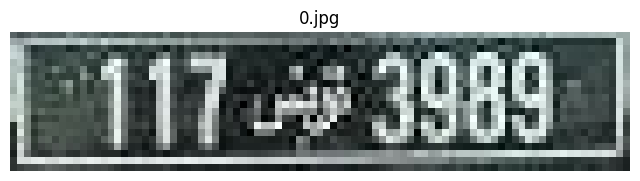

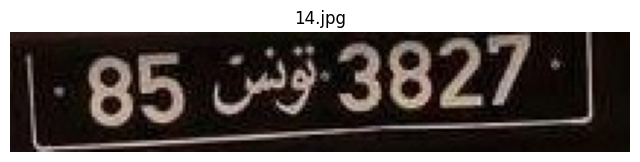

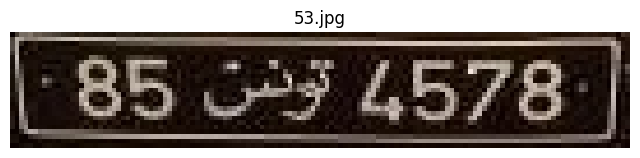

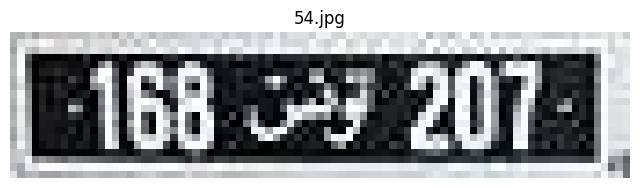

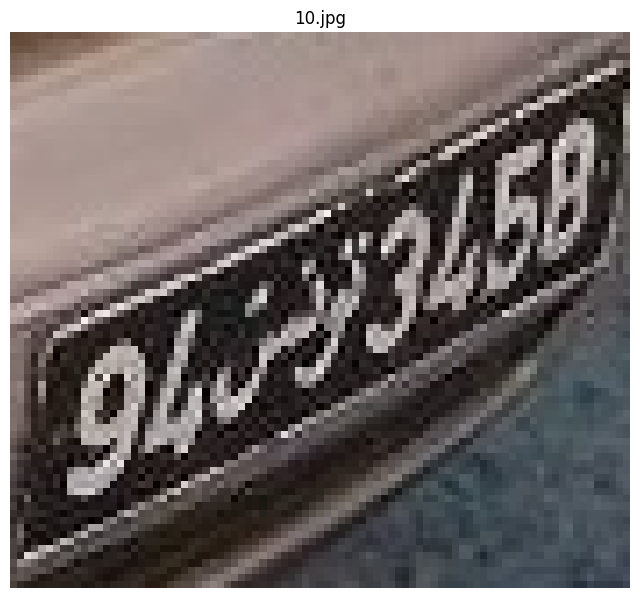

Detection Images:


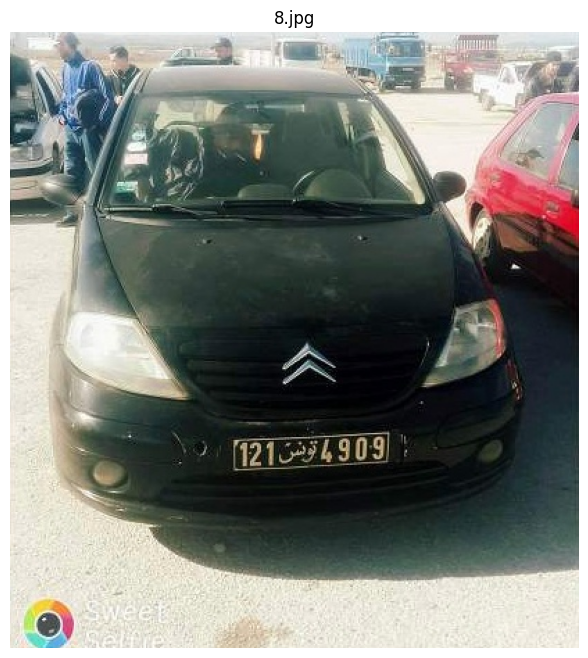

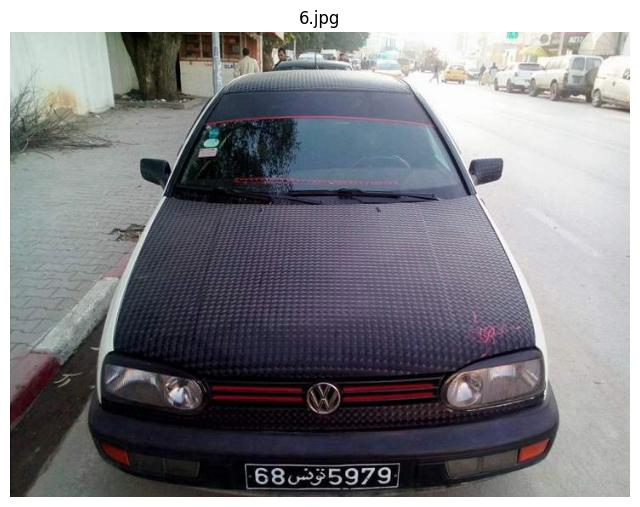

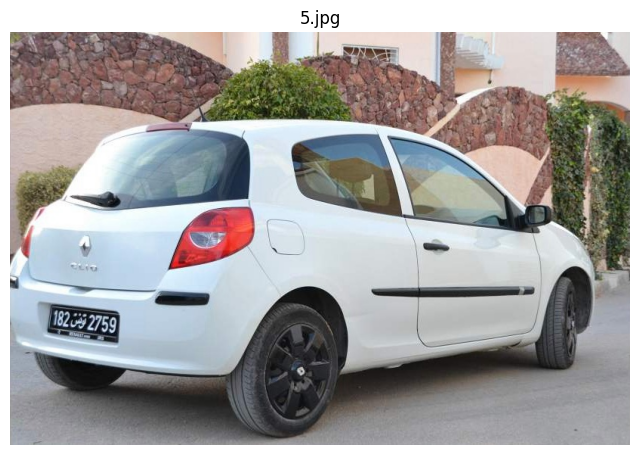

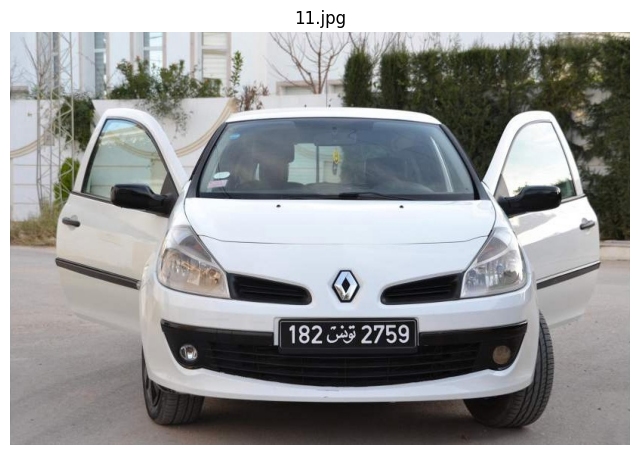

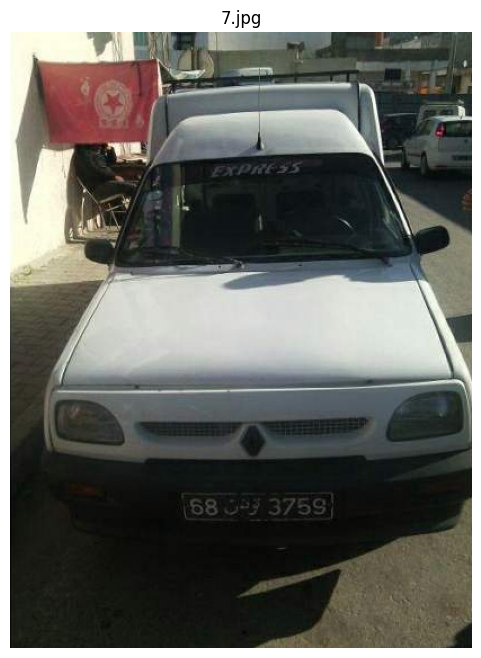

In [ ]:
def display_images(image_paths, num_images=5):
    for i in range(num_images):
        img_path = image_paths[i]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.title(os.path.basename(img_path))
        plt.axis('off')
        plt.show()

# Display a few images from each directory
print("Recognition Images:")
display_images(lp_recognition_image_paths)

print("Detection Images:")
display_images(lp_detection_image_paths)


In [ ]:
#integrate with annotations

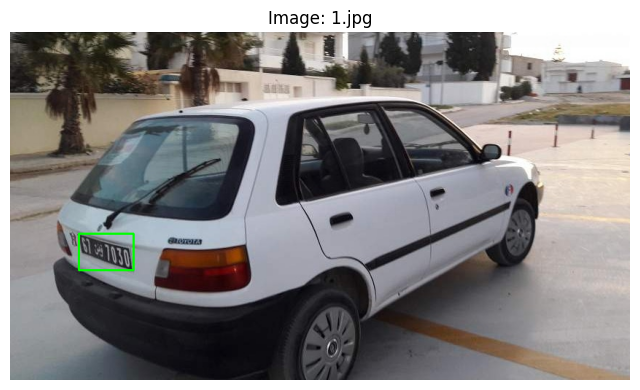

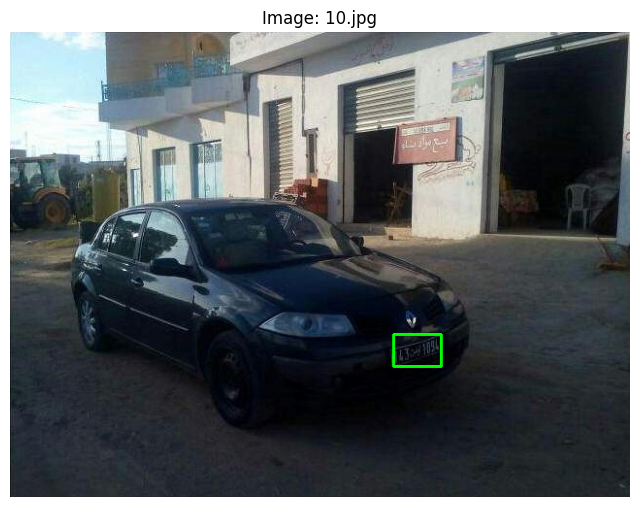

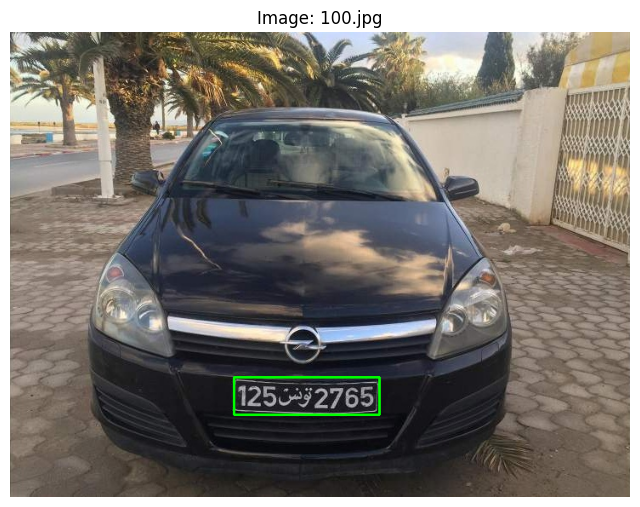

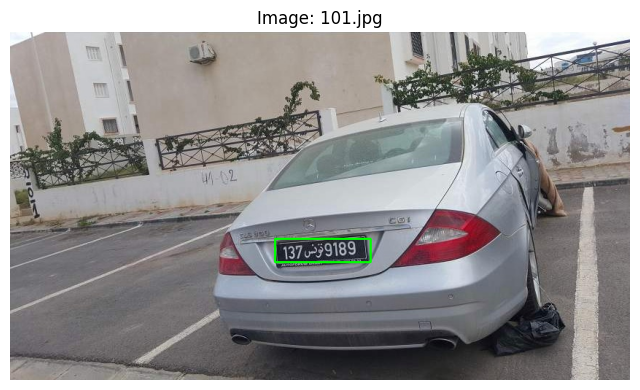

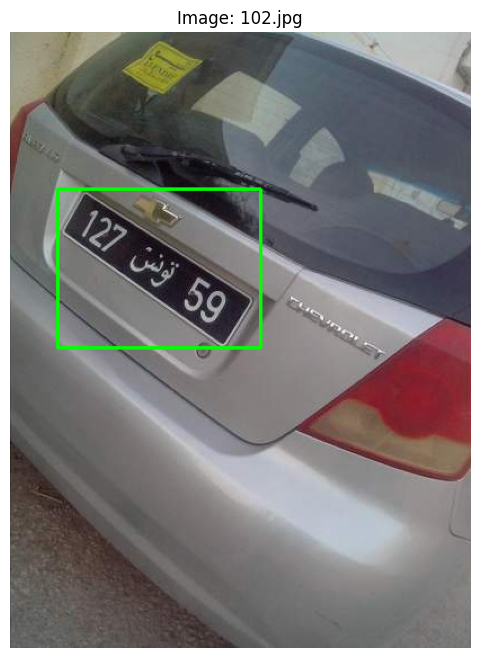

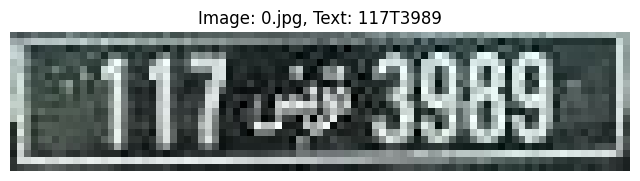

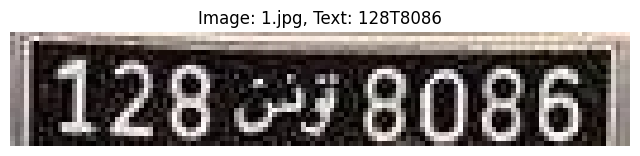

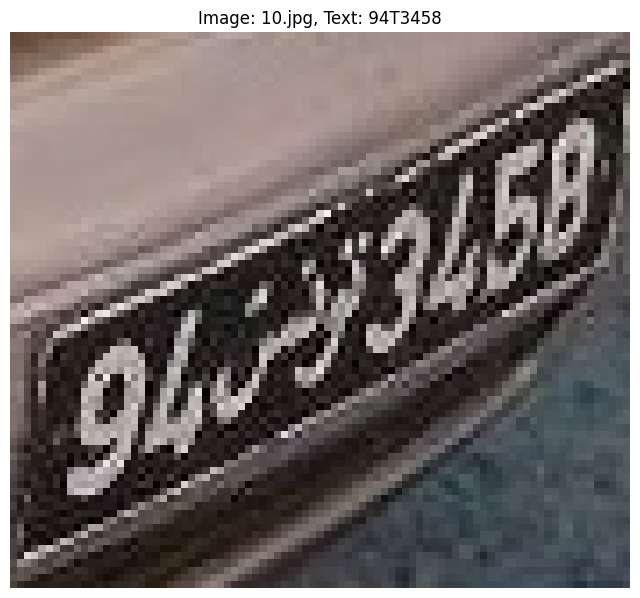

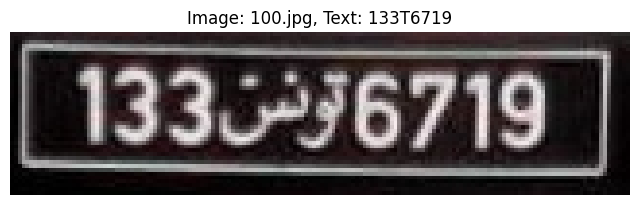

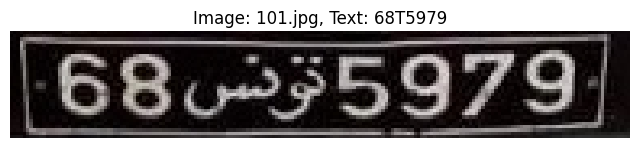

In [ ]:
def display_detection_images(image_paths, annotations, num_images=5):
    for i in range(num_images):
        img_name = annotations.iloc[i]['img_id']
        img_path = os.path.join(lp_detection_image_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display
        ymin = annotations.iloc[i]['ymin']
        xmin = annotations.iloc[i]['xmin']
        ymax = annotations.iloc[i]['ymax']
        xmax = annotations.iloc[i]['xmax']

        # Draw bounding box
        img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.title(f"Image: {img_name}")
        plt.axis('off')
        plt.show()

# Load the annotations
lp_detection_annotations = pd.read_csv(r"/content/drive/MyDrive/datascientistintern/Licplatesdetection_train.csv")

# Display detection images with annotations
display_detection_images(lp_detection_image_paths, lp_detection_annotations)

def display_recognition_images(image_paths, annotations, num_images=5):
    for i in range(num_images):
        img_name = annotations.iloc[i]['img_id']
        img_path = os.path.join(lp_recognition_image_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display

        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.title(f"Image: {img_name}, Text: {annotations.iloc[i]['text']}")
        plt.axis('off')
        plt.show()

# Load the annotations
lp_recognition_annotations = pd.read_csv(r"/content/drive/MyDrive/datascientistintern/Licplatesrecognition_train.csv")

# Display recognition images with annotations
display_recognition_images(lp_recognition_image_paths, lp_recognition_annotations)


In [ ]:
lp_detection_annotations.head(5)

img_id  ymin  xmin  ymax  xmax
0    1.jpg   276    94   326   169
1   10.jpg   311   395   344   444
2  100.jpg   406   263   450   434
3  101.jpg   283   363   315   494
4  102.jpg   139    42   280   222

In [ ]:
lp_recognition_annotations.head(5)

img_id      text
0    0.jpg  117T3989
1    1.jpg  128T8086
2   10.jpg   94T3458
3  100.jpg  133T6719
4  101.jpg   68T5979

In [ ]:
# Define image dimensions
IMAGE_SIZE = (224, 224)

In [ ]:
# Function to preprocess images for detection model
def preprocess_image_detection(img_path, annotation):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, IMAGE_SIZE)
    img_rescaled = img_resized / 255.0  # Rescale to [0, 1]
    return img_rescaled, annotation['ymin'], annotation['xmin'], annotation['ymax'], annotation['xmax']

In [ ]:
# Function to preprocess images for recognition model
def preprocess_image_recognition(img_path, annotation):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, IMAGE_SIZE)
    img_rescaled = img_resized / 255.0  # Rescale to [0, 1]
    return img_rescaled, annotation['text']

In [ ]:
# Preprocess all images and annotations for detection
X_detection = []
y_detection = []
for idx, row in lp_detection_annotations.iterrows():
    img_path = os.path.join(lp_detection_image_dir, row['img_id'])
    img_preprocessed, ymin, xmin, ymax, xmax = preprocess_image_detection(img_path, row)
    X_detection.append(img_preprocessed)
    y_detection.append([ymin, xmin, ymax, xmax])
X_detection = np.array(X_detection)
y_detection = np.array(y_detection)


In [ ]:
# Preprocess all images and annotations for recognition
X_recognition = []
y_recognition = []
for idx, row in lp_recognition_annotations.iterrows():
    img_path = os.path.join(lp_recognition_image_dir, row['img_id'])
    img_preprocessed, text = preprocess_image_recognition(img_path, row)
    X_recognition.append(img_preprocessed)
    y_recognition.append(text)
X_recognition = np.array(X_recognition)
y_recognition = np.array(y_recognition)

In [ ]:
import numpy as np

# Add channel dimension to X_recognition
X_recognition = np.expand_dims(X_recognition, axis=-1)

# Now perform the train-test split
X_recognition_train, X_recognition_val, y_recognition_train, y_recognition_val = train_test_split(
    X_recognition, y_recognition, test_size=0.2, random_state=42
)


In [ ]:
# Split data into train and validation sets
from sklearn.model_selection import train_test_split
X_detection_train, X_detection_val, y_detection_train, y_detection_val = train_test_split(X_detection, y_detection, test_size=0.2, random_state=42)
X_recognition_train, X_recognition_val, y_recognition_train, y_recognition_val = train_test_split(X_recognition, y_recognition, test_size=0.2, random_state=42)

In [ ]:
# Define detection model architecture
def create_detection_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(4)  # Output layer for bbox (ymin, xmin, ymax, xmax)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [ ]:
# Create detection model
detection_model = create_detection_model()
detection_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [ ]:
# Train detection model
detection_history = detection_model.fit(X_detection_train, y_detection_train, epochs=20, batch_size=32, validation_data=(X_detection_val, y_detection_val))

Epoch 1/20
23/23 [==============================] - 95s 4s/step - loss: 32483.7363 - mae: 136.5911 - val_loss: 18392.0352 - val_mae: 109.5457
Epoch 2/20
23/23 [==============================] - 93s 4s/step - loss: 15354.0449 - mae: 98.9347 - val_loss: 14518.8906 - val_mae: 92.1282
Epoch 3/20
23/23 [==============================] - 107s 5s/step - loss: 13592.3721 - mae: 90.8190 - val_loss: 14263.3857 - val_mae: 95.0144
Epoch 4/20
23/23 [==============================] - 97s 4s/step - loss: 13143.3789 - mae: 89.4311 - val_loss: 13273.3213 - val_mae: 91.7232
Epoch 5/20
23/23 [==============================] - 95s 4s/step - loss: 12279.5957 - mae: 86.3796 - val_loss: 15067.1260 - val_mae: 96.2609
Epoch 6/20
23/23 [==============================] - 94s 4s/step - loss: 14371.1680 - mae: 93.9655 - val_loss: 15748.0635 - val_mae: 95.5131
Epoch 7/20
23/23 [==============================] - 94s 4s/step - loss: 12865.1836 - mae: 88.4543 - val_loss: 12897.2324 - val_mae: 89.8902
Epoch 8/20
23/23 

In [ ]:
# Define recognition model architecture
def create_recognition_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Output layer for binary classification (text/no-text)
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Create recognition model
recognition_model = create_recognition_model()
recognition_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 26, 26, 128)      

In [ ]:
all_labels = np.concatenate((y_recognition_train, y_recognition_val))
import sklearn.preprocessing # Import the preprocessing module from scikit-learn

le = sklearn.preprocessing.LabelEncoder() # Create a LabelEncoder object

le.fit(all_labels)  # Fit on all labels

y_recognition_train_numerical = le.transform(y_recognition_train)
y_recognition_val_numerical = le.transform(y_recognition_val)

In [ ]:

# Encode validation labels
y_recognition_val_numerical = le.transform(y_recognition_val)

# Train recognition model
recognition_history = recognition_model.fit(
    X_recognition_train,
    y_recognition_train_numerical,
    epochs=20,
    batch_size=32,
    validation_data=(X_recognition_val, y_recognition_val_numerical)  # Use encoded validation labels
)

Epoch 1/20
23/23 [==============================] - 87s 4s/step - loss: -27148088.0000 - accuracy: 0.0000e+00 - val_loss: -340365088.0000 - val_accuracy: 0.0056
Epoch 2/20
23/23 [==============================] - 85s 4s/step - loss: -27295627264.0000 - accuracy: 0.0000e+00 - val_loss: -188965011456.0000 - val_accuracy: 0.0056
Epoch 3/20
23/23 [==============================] - 83s 4s/step - loss: -2865955340288.0000 - accuracy: 0.0000e+00 - val_loss: -14146291630080.0000 - val_accuracy: 0.0056
Epoch 4/20
23/23 [==============================] - 83s 4s/step - loss: -96077395001344.0000 - accuracy: 0.0000e+00 - val_loss: -356720287154176.0000 - val_accuracy: 0.0056
Epoch 5/20
23/23 [==============================] - 82s 4s/step - loss: -1521951189237760.0000 - accuracy: 0.0000e+00 - val_loss: -4530412571328512.0000 - val_accuracy: 0.0056
Epoch 6/20
23/23 [==============================] - 87s 4s/step - loss: -14244946231951360.0000 - accuracy: 0.0000e+00 - val_loss: -36327237116493824.00

In [ ]:
#test data set below

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 26, 26, 128)      

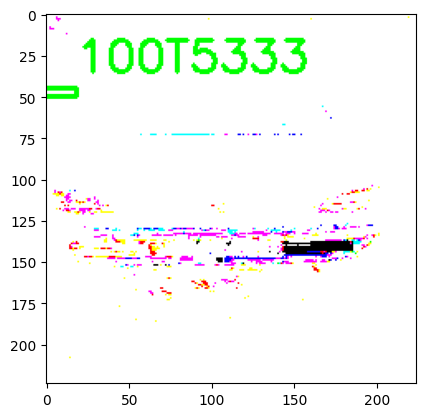

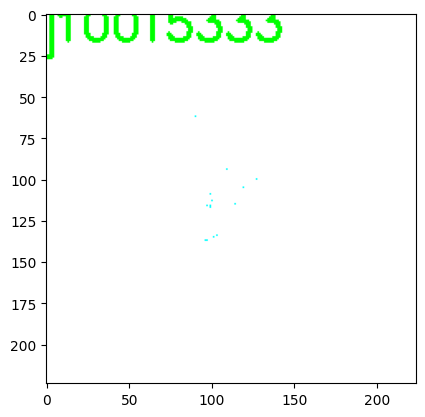

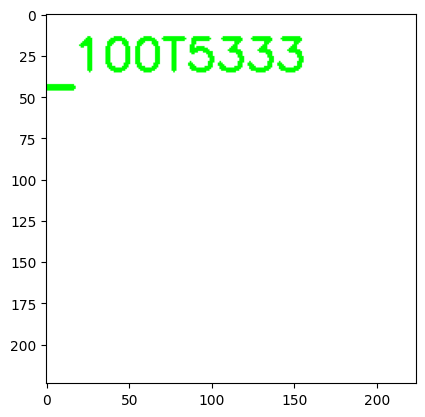

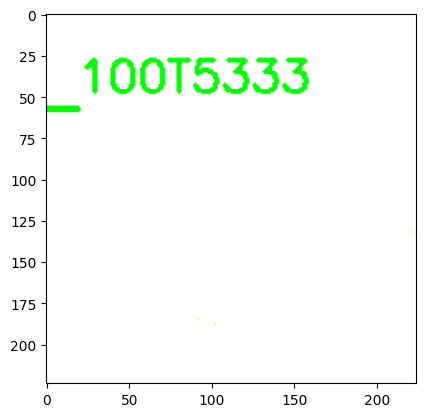

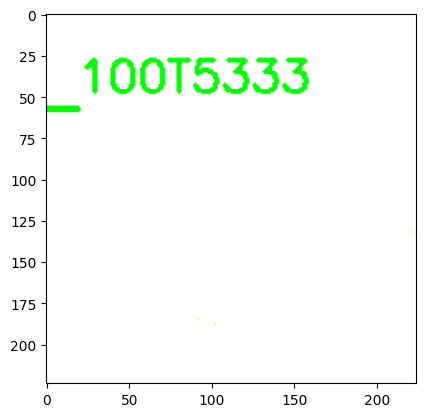

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

# Load test images in color (BGR)
def load_test_images(test_image_dir, target_size=(224, 224)):
    images = []
    filenames = []
    for filename in os.listdir(test_image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(test_image_dir, filename)
            img = cv2.imread(img_path)  # Load images in color (BGR)
            img = cv2.resize(img, target_size)
            img = img_to_array(img)
            images.append(img)
            filenames.append(filename)
    images = np.array(images)
    return images, filenames

# Function to plot detected number plate
def plot_detected_number_plate(img, bbox, plate_text):
    (x, y, w, h) = bbox
    # Convert coordinates to integers
    x, y, w, h = int(x), int(y), int(w), int(h)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Handle cases where plate_text might be invalid
    if plate_text is not None and plate_text.size > 0:  # Check if plate_text is valid and not empty
        predicted_index = np.argmax(plate_text)
        if predicted_index < len(le.classes_):  # Check if index is within bounds
            predicted_character = le.inverse_transform([predicted_index])[0]
            cv2.putText(img, predicted_character, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

# Load test images
test_image_dir = r"/content/drive/MyDrive/datascientistintern/test"
X_test, test_filenames = load_test_images(test_image_dir)

# Load your pre-trained detection and recognition models
detection_model = create_detection_model()
recognition_model = create_recognition_model()

# Debugging: Print model summaries
detection_model.summary()
recognition_model.summary()

# Use detection model to detect number plates
detected_number_plates = []
for img in X_test:
    img_input = np.expand_dims(img, axis=0)
    detected_boxes = detection_model.predict(img_input)
    print(f"Detected boxes: {detected_boxes}")  # Debugging: Print detected boxes
    detected_number_plates.append(detected_boxes)

# Use recognition model to recognize characters on detected number plates
recognized_texts = []
for img, bbox in zip(X_test, detected_number_plates):
    (x, y, w, h) = bbox[0]  # Assuming bbox is the first box detected
    print(f"Bounding box: x={x}, y={y}, w={w}, h={h}")  # Debugging: Print bounding box coordinates

    # Ensure bounding box coordinates are non-negative and within image bounds
    x = max(0, int(x))
    y = max(0, int(y))
    w = min(img.shape[1] - x, int(w))  # Ensure width does not exceed image bounds
    h = min(img.shape[0] - y, int(h))  # Ensure height does not exceed image bounds

    number_plate_img = img[y:y+h, x:x+w]

    # Check if number_plate_img is empty
    if number_plate_img.size == 0:
        print("Warning: Empty number plate image encountered. Skipping recognition.")
        recognized_texts.append(None)
        continue

    number_plate_img = cv2.resize(number_plate_img, (224, 224))
    # Convert the number plate image to grayscale
    number_plate_img = cv2.cvtColor(number_plate_img, cv2.COLOR_BGR2GRAY)
    number_plate_img = np.expand_dims(number_plate_img, axis=0)
    number_plate_img = np.expand_dims(number_plate_img, axis=-1) # Add channel dimension
    recognized_text = recognition_model.predict(number_plate_img)
    print(f"Recognized text: {recognized_text}")  # Debugging: Print recognized text
    recognized_texts.append(recognized_text)

# Plot detected number plates with recognized text
for img, bbox, text in zip(X_test, detected_number_plates, recognized_texts):
    if text is not None:  # Check if text is valid before trying to access it
        plot_detected_number_plate(img, bbox[0], text[0])
